# Teleco Customer Churn Analysis

## Project Overview
This notebook contains a comprehensive analysis of customer churn prediction for a telecommunications company. The analysis includes:

- **Exploratory Data Analysis (EDA)**: Understanding customer demographics and how it affects churn
- **Feature Engineering**: Creating meaningful features to help improve model performance
- **Model Development**: Building and evaluating machine learning models
- **Model Interpretation**: Using SHAP explainability to understand model predictions
- **Deployment**: Deplyment of model using FastAPI which runs inference and returns predictions to streamlit app
- **AI-Powered Insights**: Making use of AI to generate actionable insights and recommendations

#### Data Dictionary
* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from zipfile import ZipFile
from pathlib import Path
from typing import List, Tuple
from IPython.display import Markdown



from src import eda, preprocessing, feature_engineering, model_utils, inference
warnings.filterwarnings(action='ignore')

In [3]:
telecom_df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
telecom_df, num_cols, cat_cols = preprocessing.preprocess_df(telecom_df)
df= telecom_df.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2281.912360
std,24.559481,30.090047,2265.272185
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,402.225000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


In [6]:
df.iloc[:, :12].head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No


In [7]:
df.iloc[:, 12:].head()

,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


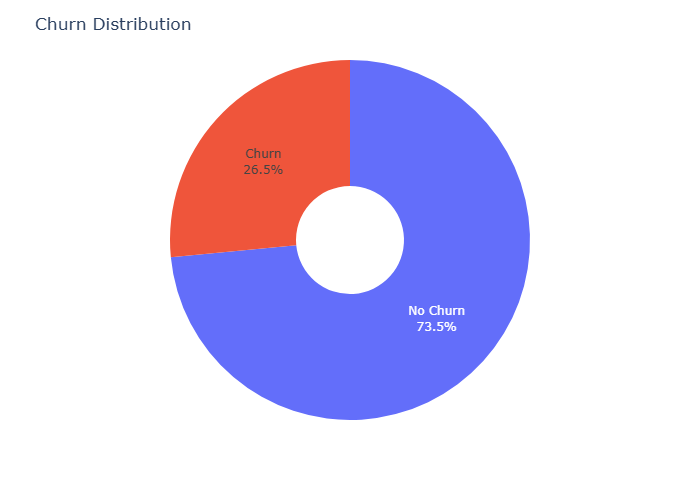

In [8]:
import plotly.io as pio
pio.renderers.default='png'
eda.plot_churn_distribution(df)

In [9]:
df.select_dtypes(include='object')

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,7590-VHVEG,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,5575-GNVDE,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,3668-QPYBK,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,7795-CFOCW,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,9237-HQITU,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,No
7039,2234-XADUH,Female,0,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),No
7040,4801-JZAZL,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
7041,8361-LTMKD,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,Yes


### EDA

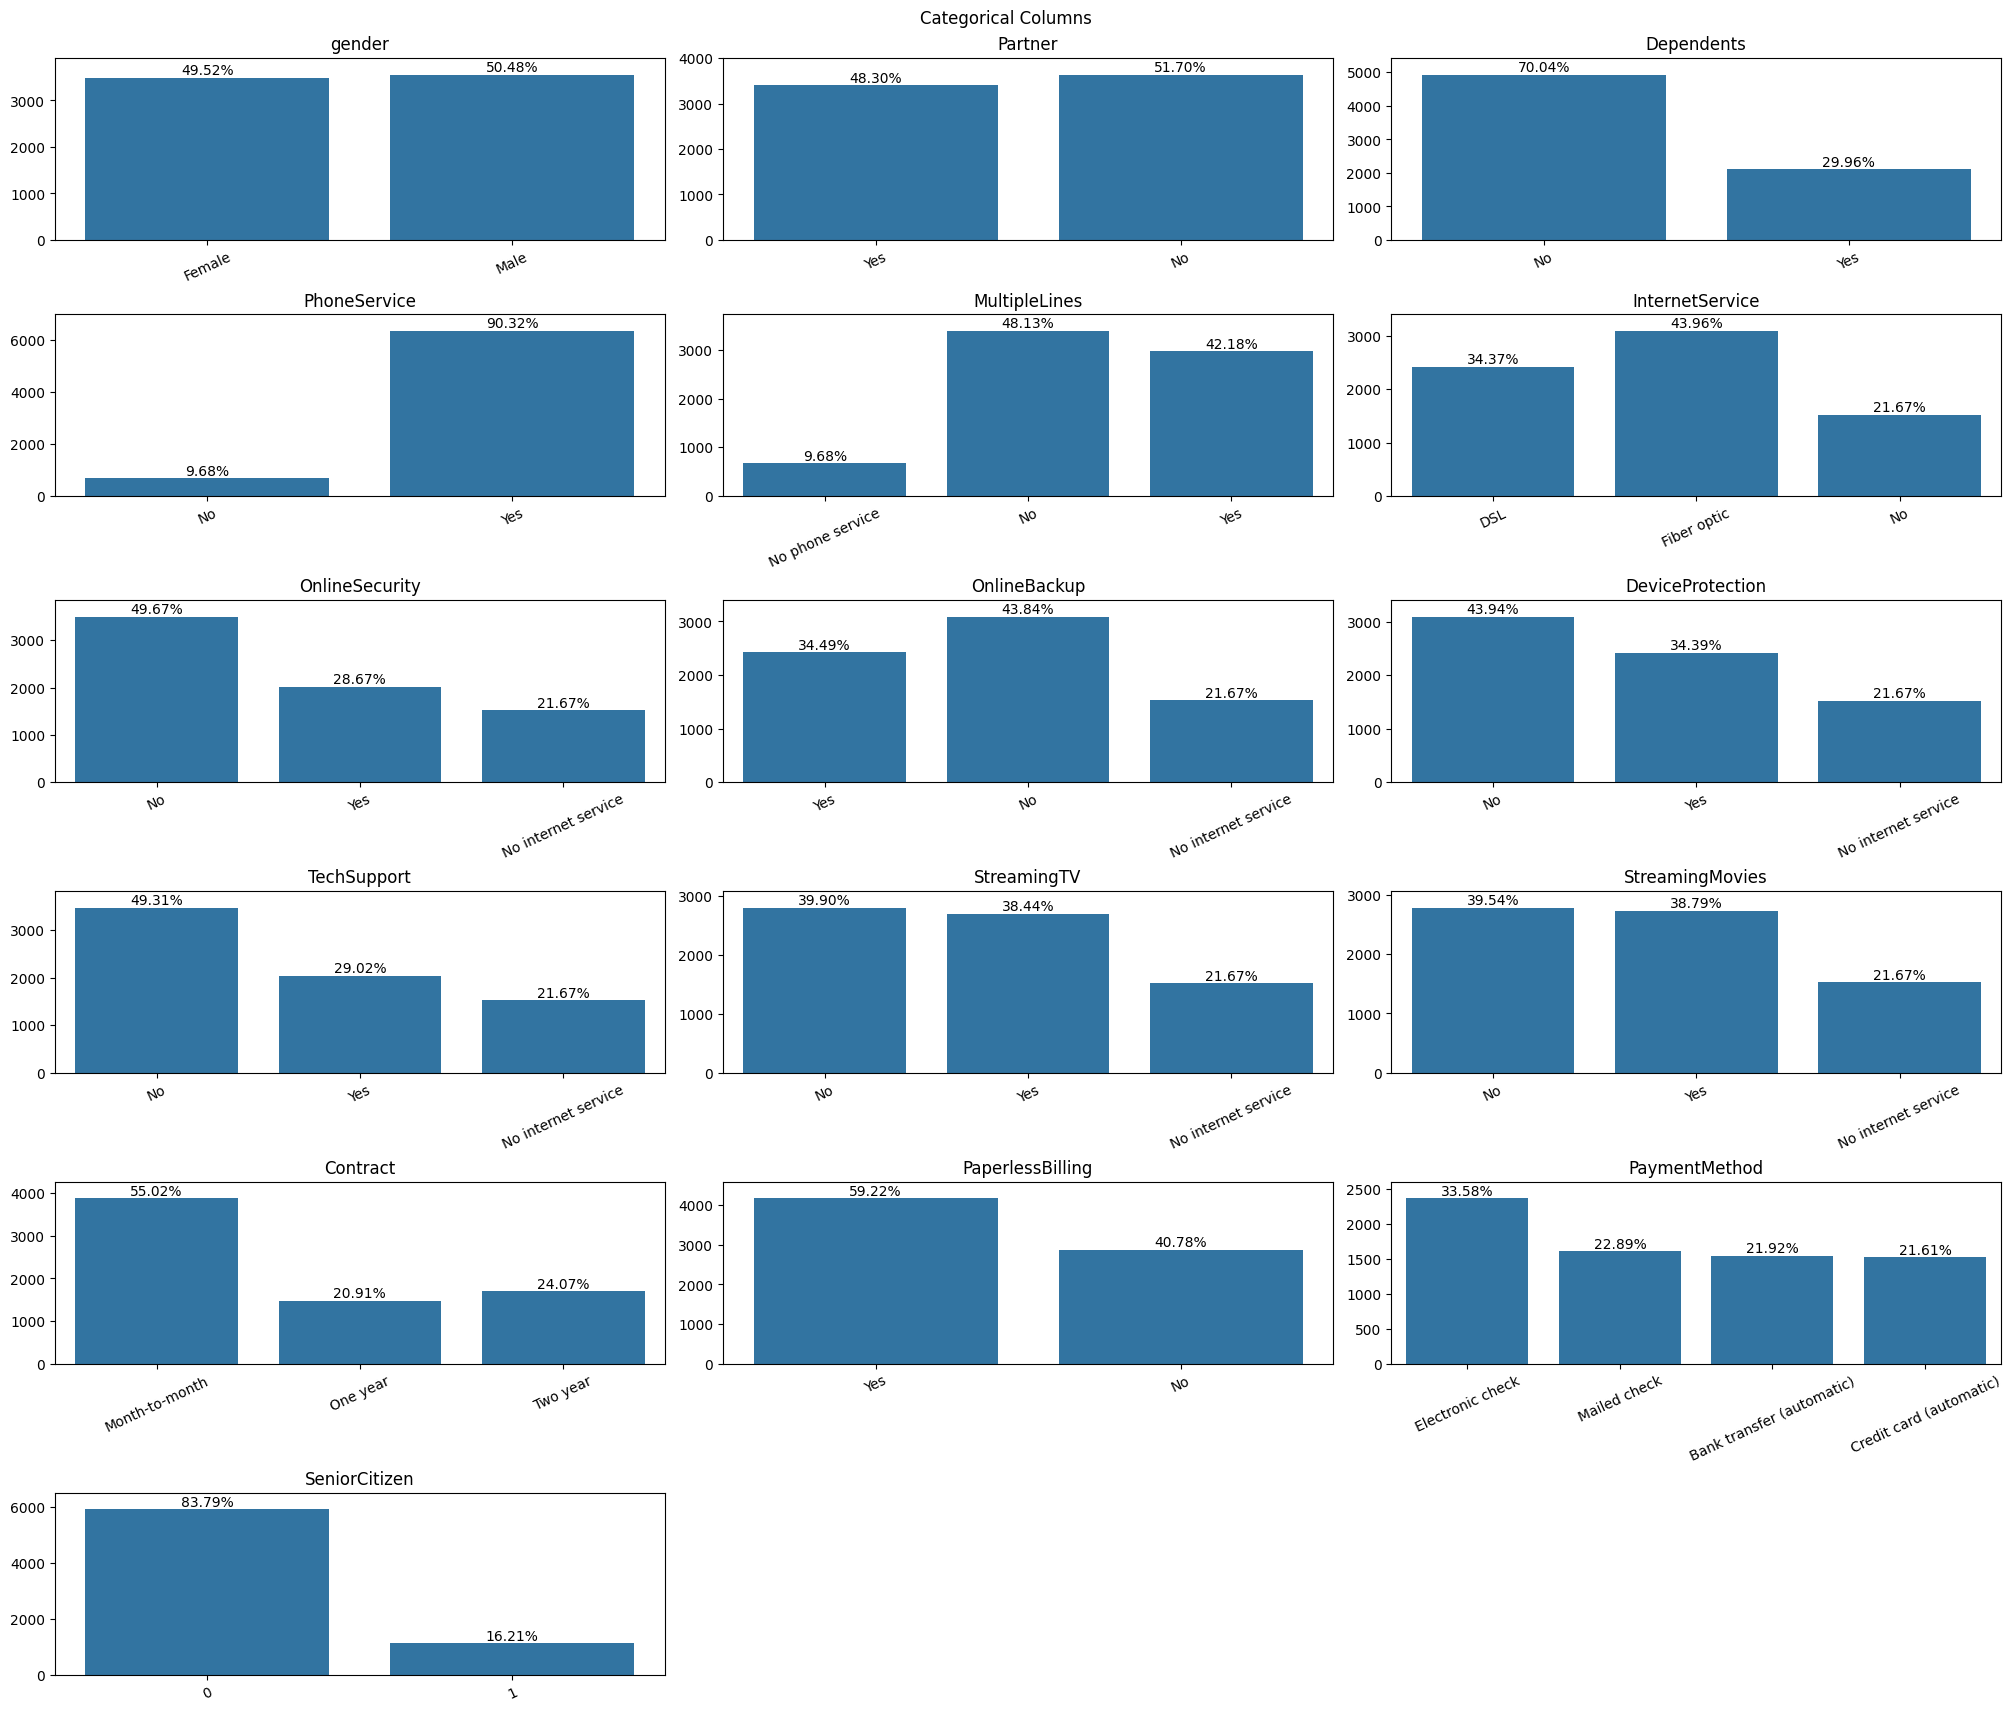

In [9]:
eda.plot_cat_cols(df=df, cat_cols=cat_cols[:])


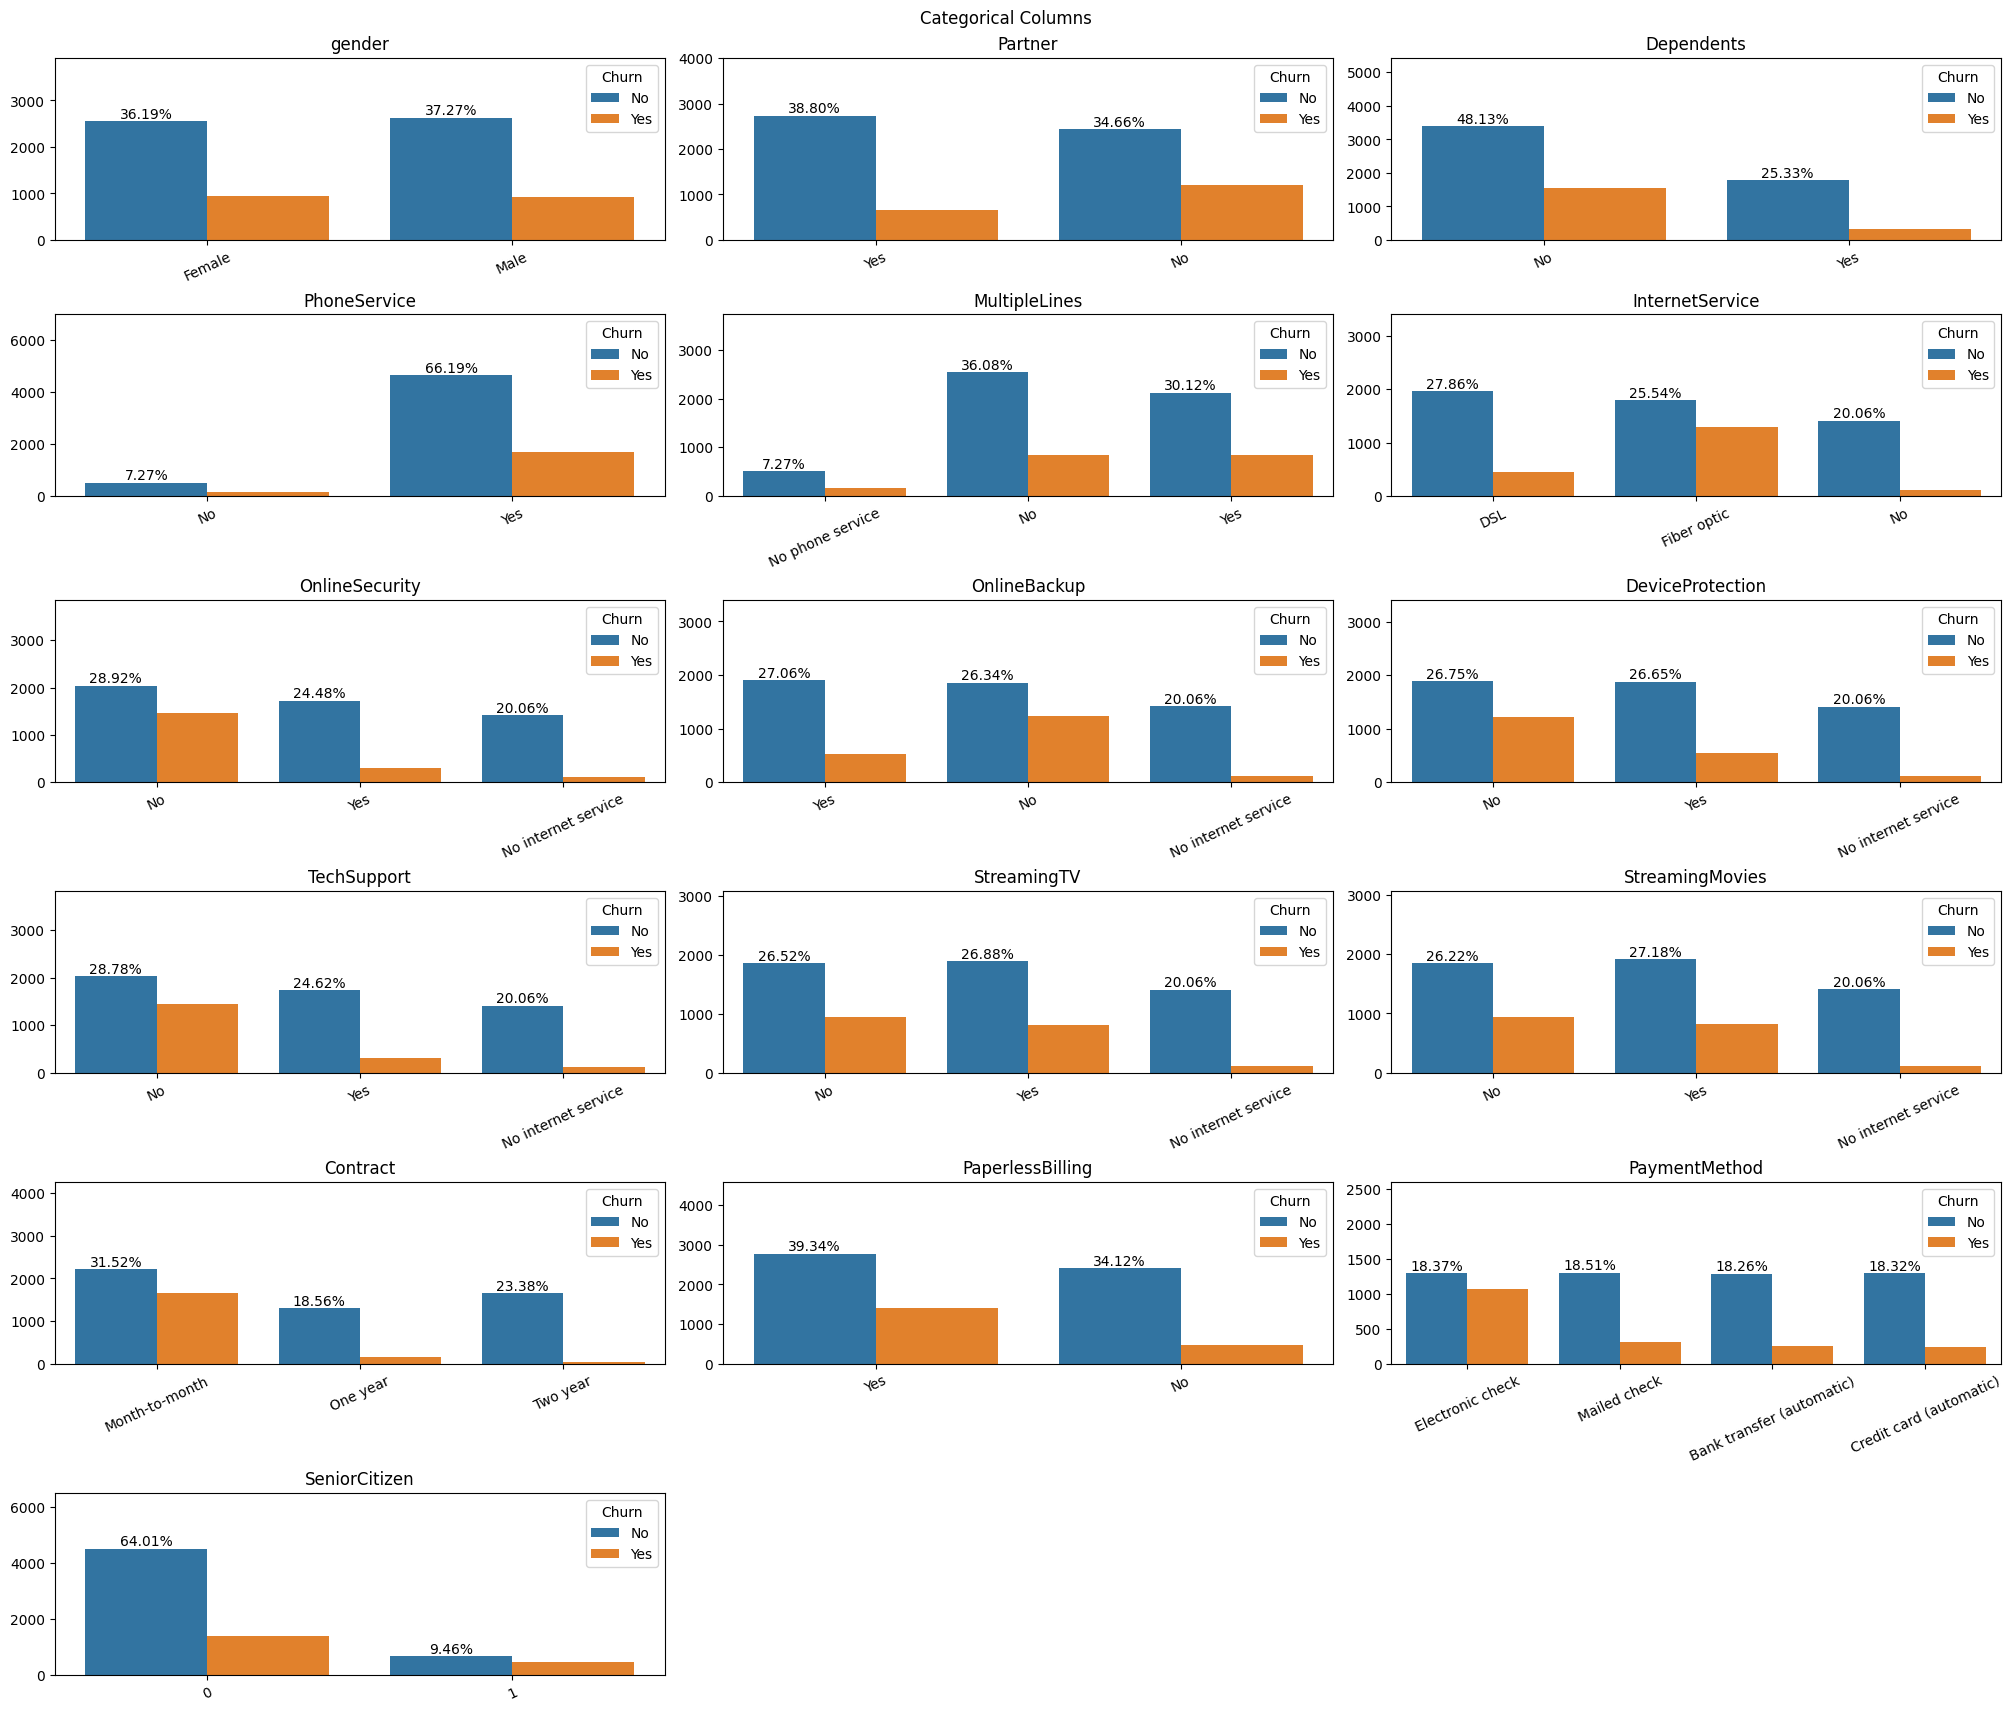

In [10]:
eda.plot_cat_cols(df, cat_cols, hue=True) 

##### Now, let's focus on the churn ratio to see what customer categories tend to churn the most, I'll firstly start with the 5 columns

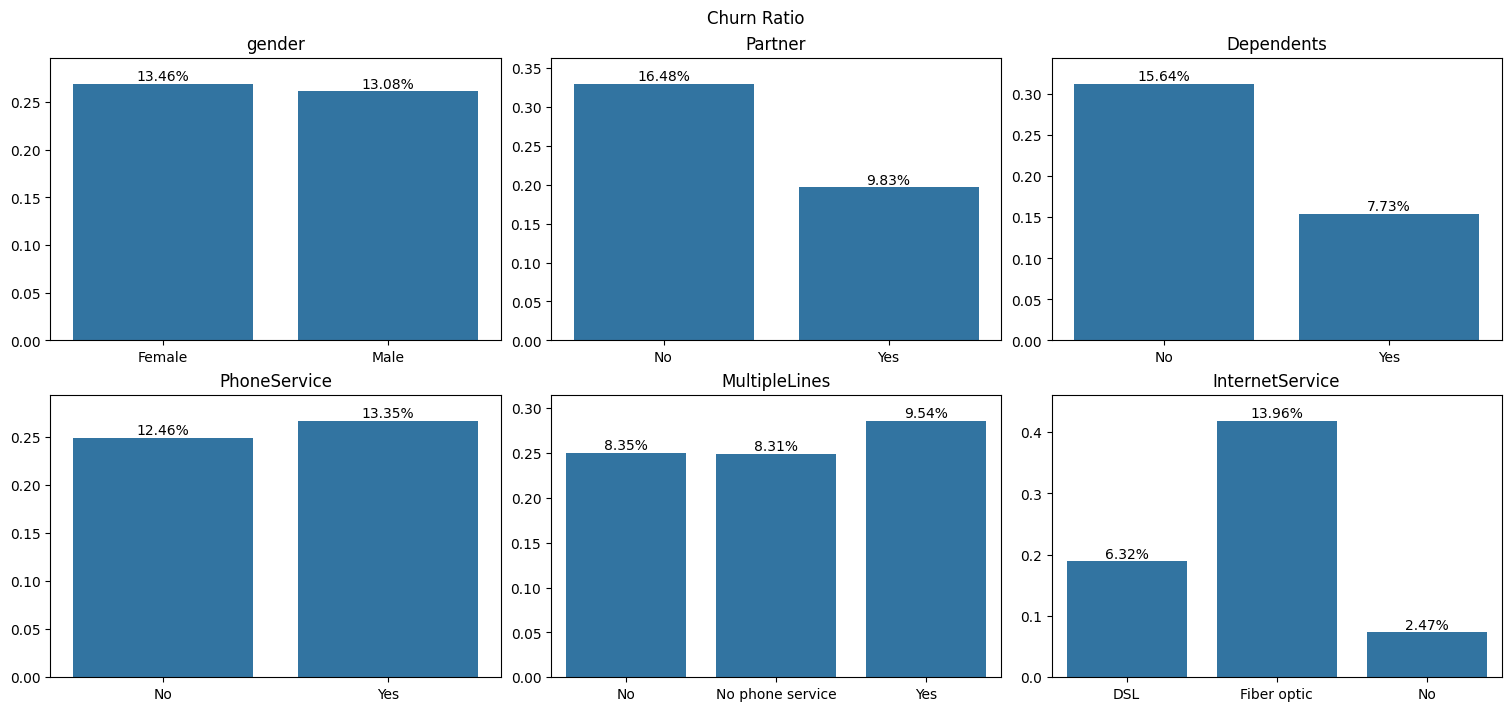

In [11]:
eda.plot_churn_ratio(df, cat_cols=cat_cols[:6], nrows=2, figsize=(15, 7))

##### From the above plots, we see the following:
1. **Females** tend to churn more than **Males** but the difference isn't that large
2. Those with **no partners** tend to churn about ***two times*** than those with partners
3. Those with **depenedents** churn ***significantly higher*** than those with no **dependents**
4. **Fiber Optic** Subscribers churn at a very ***high*** rate

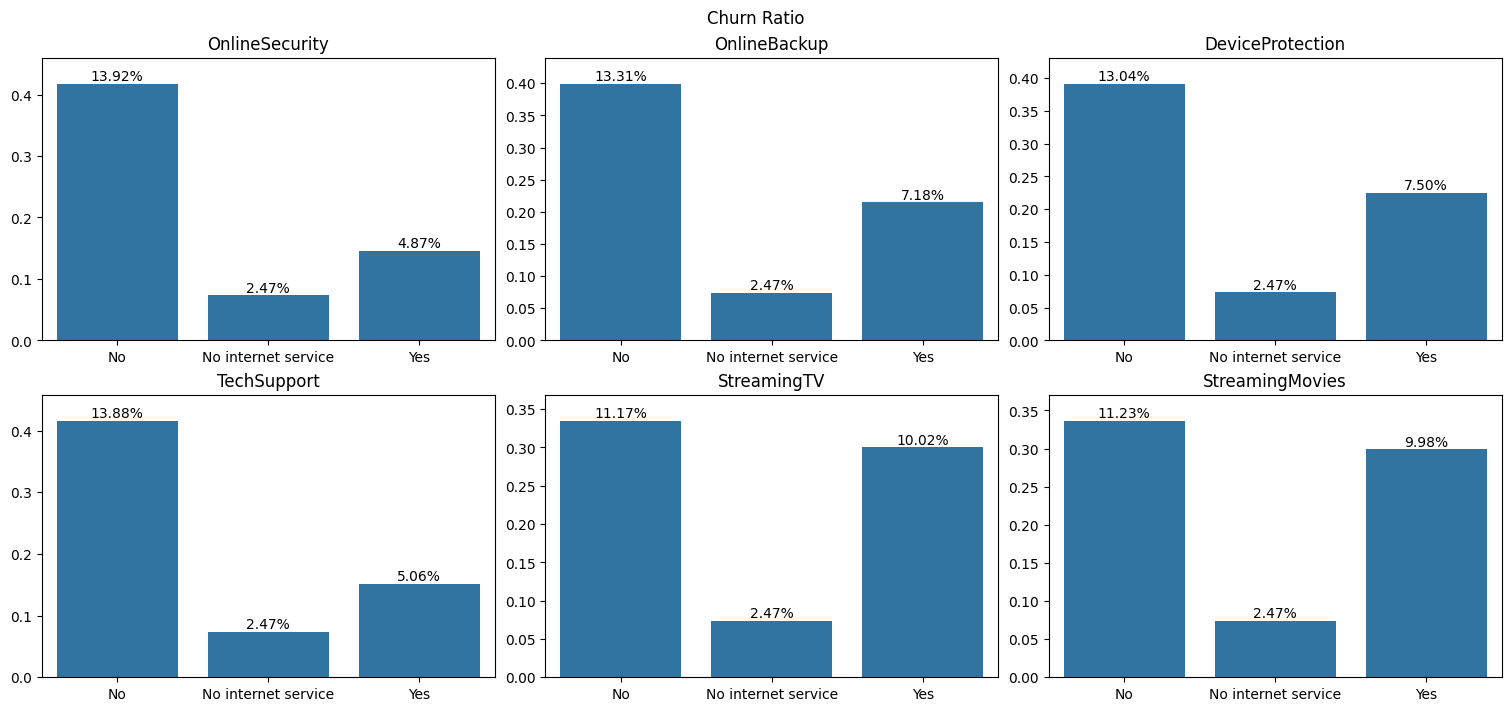

In [12]:
eda.plot_churn_ratio(df, cat_cols[6:12], nrows=2)

##### Again, from the above we can observe the following:
1. **Online Security**, **Online Backup**, **Device Protection** and **Tech Support** are ***highly*** important to avoid customers churning
2. Customers who do ***not*** stream movies and TV churn ***slightly less*** than those who stream them

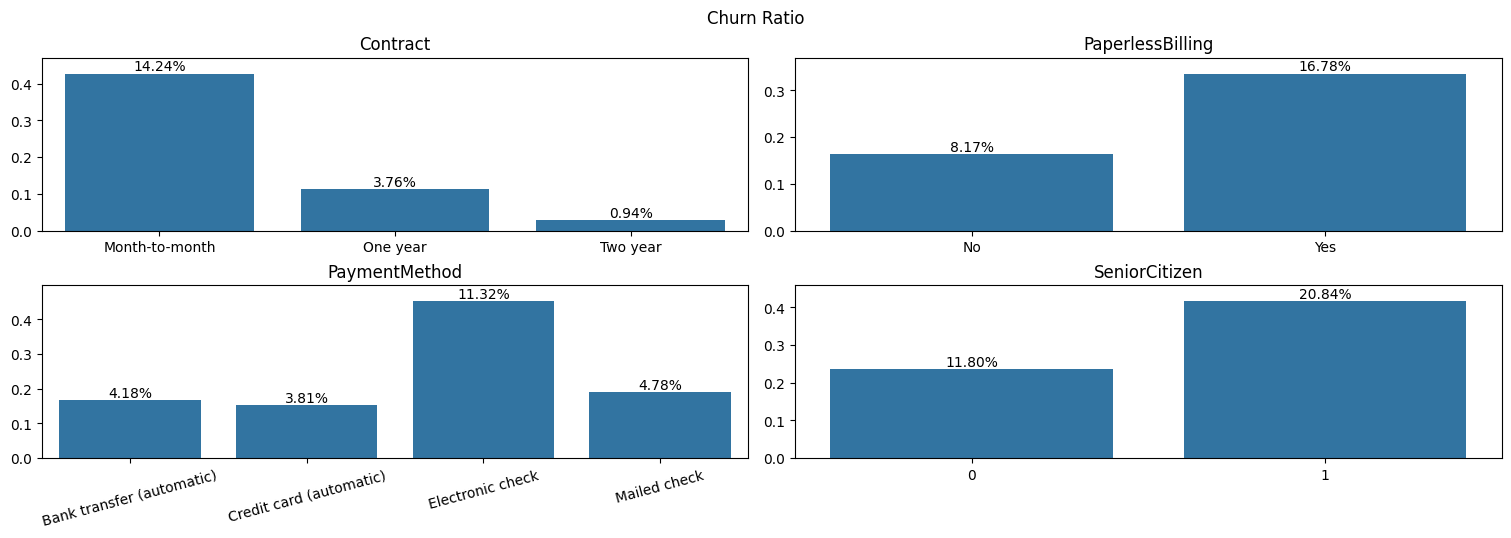

In [13]:
eda.plot_churn_ratio(df, cat_cols[12:18])

##### Again, we can observe the following:
1. Customers who make **monthly** payments churn at a very high rate compared to customers on **annual** or **biennial** contracts, this suggests we should focus on moving customers to ***longer term*** plans
2. Customers are billed via ***paperless*** formats are signifinactly more likely to churn
3. Customers who make payments via **electronic checks** are highly mor ***likely** to churn compared to other payment means
4. Senior citizens are ***highly*** likely to churn compared to ***non-senior*** citizens

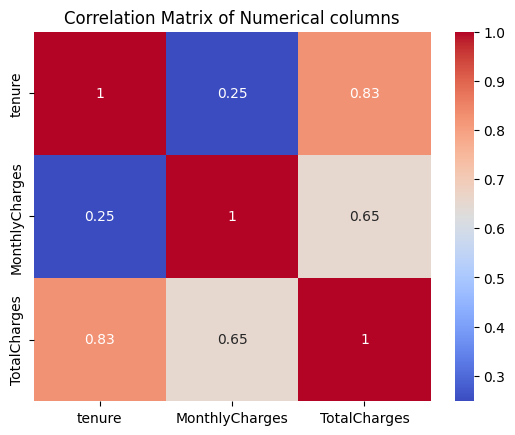

In [14]:
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title(f"Correlation Matrix of Numerical columns");

I'll prolly drop `monthly_charges` column since `total charges` is a product of `tenure` and `monthly_charges`, 

In [15]:
df.groupby(['Contract', 'Churn'])['MonthlyCharges'].agg(['mean', 'median'])

mean  median
Contract       Churn                   
Month-to-month No     61.462635  64.950
               Yes    73.019396  79.050
One year       No     62.508148  64.850
               Yes    85.050904  95.050
Two year       No     60.012477  63.300
               Yes    86.777083  97.275

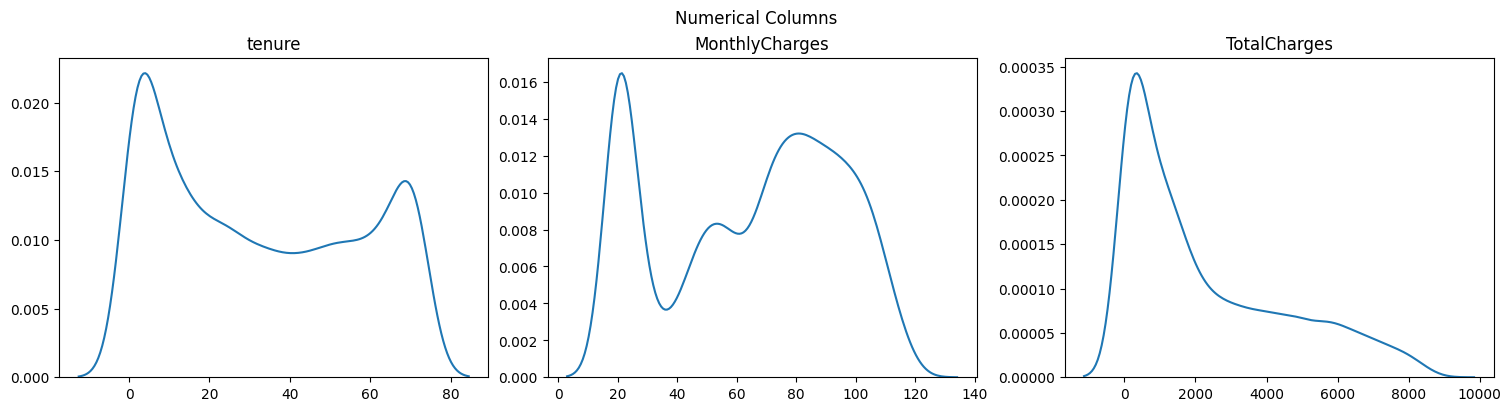

In [16]:
eda.plot_num_cols(df, num_cols, kde=True)

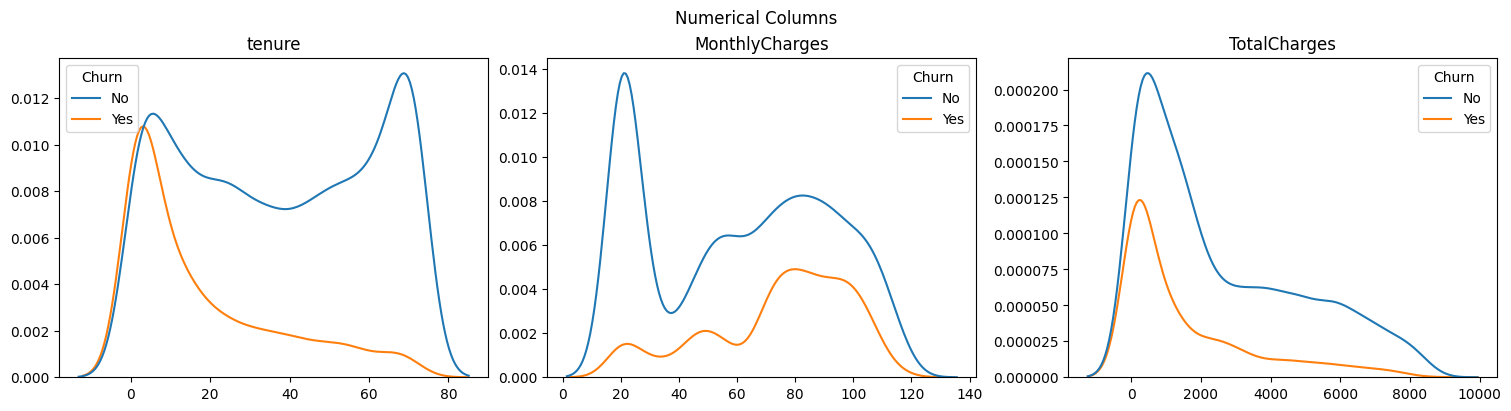

In [17]:
eda.plot_num_cols(df, num_cols, hue=True, kde=True)

##### From the above of our numerical columns we note the following:
1. Customers tend to churn the most in the first 15 months, after that, they become really loyal and stick with the brand
2. ***High paying*** customers, **($70-$100)** tend to churn a lot, than low paying customers
3. It might look like ***customers who sepend less churn, but since `total charges` is a product of `tenure` and `monthly_charges`, we naturally expect early churners to have ***lower*** charges

### Feature Engineering

From my EDA, I saw that `contract_type` and `tenure` significantly affected churn, so im thinking of creating categories for them so as to help me my models get these strong signals.

In [2]:
telecom_df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
telecom_df, num_cols, cat_cols = preprocessing.preprocess_df(telecom_df)
df= telecom_df.copy()
initial_columns = telecom_df.columns
df = feature_engineering.binary_enc(df)
df = feature_engineering.service_count(df)
df = feature_engineering.check_price_increase(df)
df, model_scaler, model_kmeans = feature_engineering.cluster_customers(df)
df, model_one_hot_encoder = feature_engineering.encode_cat_cols(df, cat_cols=cat_cols)
# cols_to_drop = ['customerID', ]

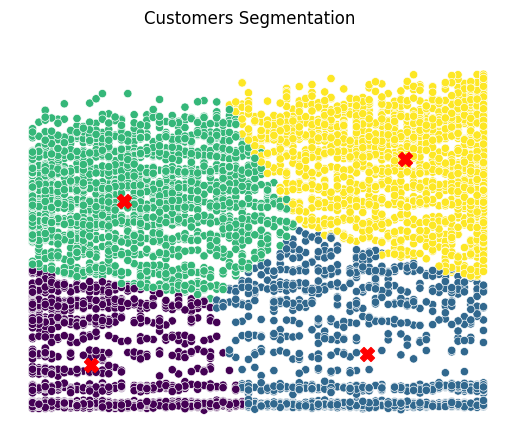

In [3]:
feature_engineering.cluster_customers(df, visualize=True)

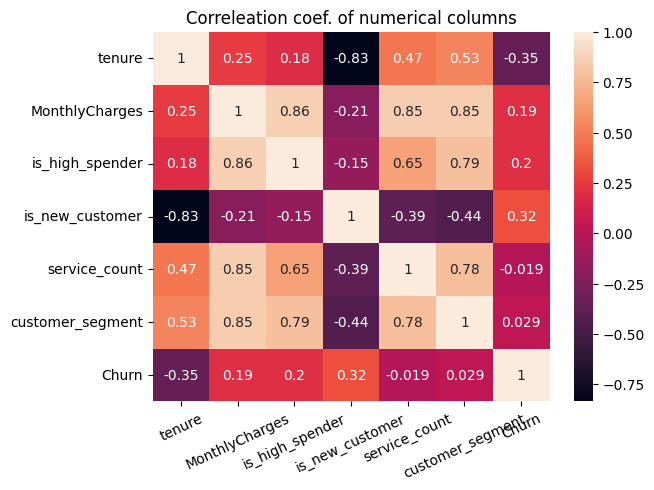

In [4]:
sns.heatmap(df[['tenure', 'MonthlyCharges', 'is_high_spender', 'is_new_customer', 'service_count', 'customer_segment', 'Churn']].corr(),\
            annot=True)
plt.xticks(rotation=25)
plt.title(f"Correleation coef. of numerical columns");

##### Model Building

I will first start with a `DummyClassifier` to establish our baseline model. So this let's us know if future models are performing any better

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score,\
                                                 roc_curve, precision_recall_curve, fbeta_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)
X_train, X_test, y_train, y_test = model_utils.split_data(df)
dummy_model, dummy_preds, _ =model_utils.train_model(DummyClassifier(strategy='most_frequent'), [X_train, X_test, y_train, y_test])

DummyClassifier
Train: 0.734685598377282 | Test: 0.73450070989115 | Accuracy: 0.73450070989115


Now that we have established our baseline accuracy, we can move on to building our models

In [88]:
print(f"Original Distribution\n {df['Churn'].value_counts(normalize=True)}")
smote = SMOTE(random_state=50)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"\nPost Sampling Distribution\n {y_train_resampled.value_counts(normalize=True)}")

Original Distribution
 Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

Post Sampling Distribution
 Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


In [1242]:
imb_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=50)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=50))
])
xgb_smote_model, xgb_smote_preds, xgb_smote_pred_proba = model_utils.train_model(imb_pipeline, [X_train, X_test, y_train, y_test])
logreg, logred_pred, logreg_pred_proba = model_utils.train_model(LogisticRegression(max_iter=3000), [X_train, X_test, y_train, y_test])
rf_model, rfpreds, rf_pred_proba = model_utils.train_model(RandomForestClassifier(), [X_train, X_test, y_train, y_test])
xgb_model, xgb_preds, xgb_pred_proba  = model_utils.train_model(XGBClassifier(scale_pos_weight=sum(y_train ==0) / sum(y_train==1)), [X_train, X_test, y_train, y_test])


Pipeline
Train: 0.9600405679513184 | Test: 0.754850922858495 | Accuracy: 0.754850922858495
LogisticRegression
Train: 0.8152129817444219 | Test: 0.7893989588263133 | Accuracy: 0.7893989588263133
RandomForestClassifier
Train: 0.9981744421906694 | Test: 0.7718883104590629 | Accuracy: 0.7718883104590629
XGBClassifier
Train: 0.9561866125760649 | Test: 0.7463322290582111 | Accuracy: 0.7463322290582111


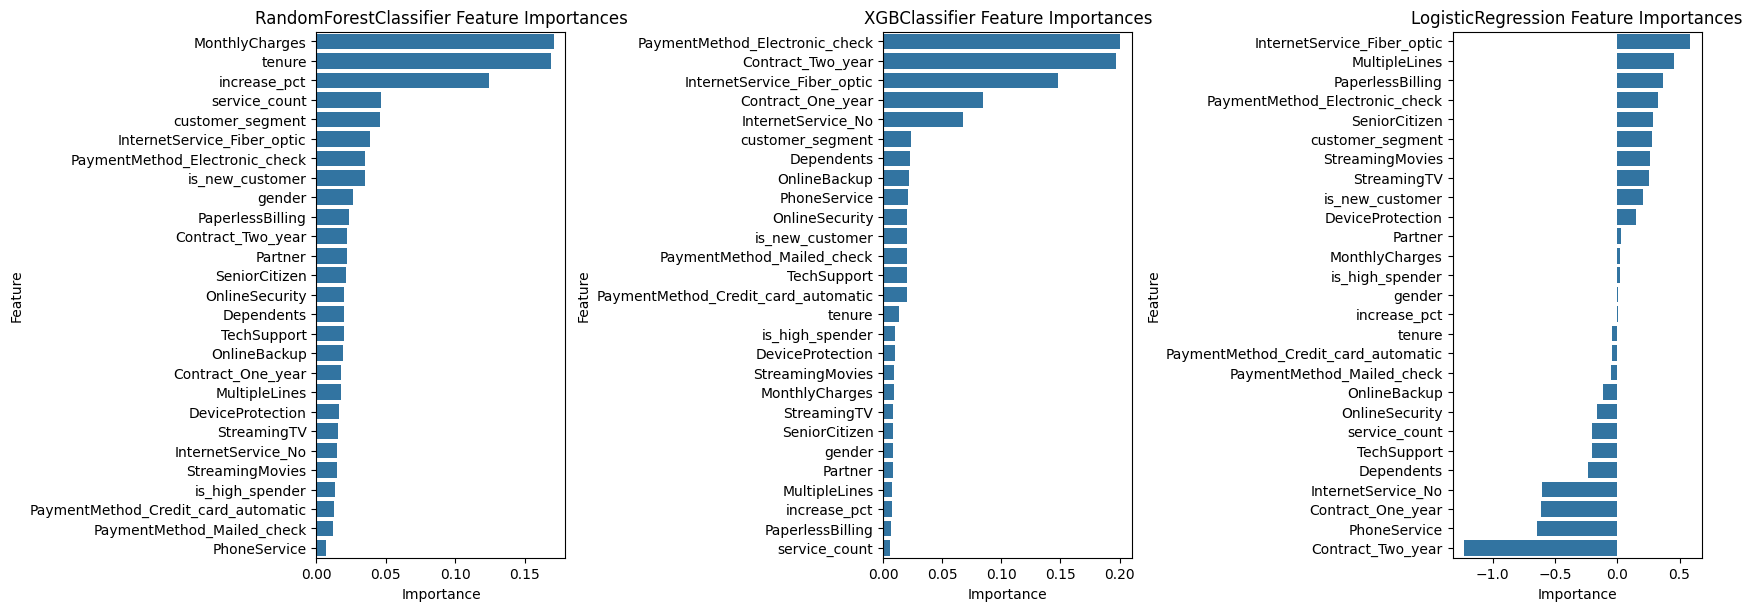

In [1243]:
fig, ax =plt.subplots(nrows=1, ncols=3, figsize=(17, 6), constrained_layout=True)

plt.sca(ax[0])
rf_feat_imp = model_utils.plot_feature_importance(rf_model)
plt.sca(ax[1])
xgb_smote_feat_imp = model_utils.plot_feature_importance(xgb_smote_model[1])
plt.sca(ax[2])
logreg_feat_imp = model_utils.plot_feature_importance(logreg)


##### Model Evaluation

From a business perspective, missing out on a churner (False Negative) is worse than wrongly predicting that a customer would churn (False Positive), so it's better to try to optimize `recall` here. But this dosen't mean that I'll be completely disregarding `precision`.

In [1244]:
logreg_recall, logreg_precision, logreg_f1 = model_utils.evaluate_model(logreg, y_test, logred_pred, logreg_pred_proba)
rf_recall, rf_precision, rf_f1 = model_utils.evaluate_model(rf_model, y_test, rfpreds, rf_pred_proba)
xgb_smote_recall, xgb_smote_precision, xgb_smote_f1 = model_utils.evaluate_model(xgb_smote_model, y_test, xgb_smote_preds, xgb_smote_pred_proba)
basic_xgb_recall, basic_xgb_precision,basic_xgbg_f1 = model_utils.evaluate_model(xgb_model, y_test, xgb_preds, xgb_pred_proba)

LogisticRegression
ROC AUC SCORE: 0.831

Classification report

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1552
           1       0.62      0.53      0.57       561

    accuracy                           0.79      2113
   macro avg       0.73      0.71      0.72      2113
weighted avg       0.78      0.79      0.78      2113

RandomForestClassifier
ROC AUC SCORE: 0.815

Classification report

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1552
           1       0.58      0.49      0.53       561

    accuracy                           0.77      2113
   macro avg       0.70      0.68      0.69      2113
weighted avg       0.76      0.77      0.76      2113

Pipeline
ROC AUC SCORE: 0.807

Classification report

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1552
           1       0.54      0.53      0.53       5

So far, my models have been confident in their predictions with a `roc_auc_score` > 0.8 but the `recall` scores have generally been poor. 

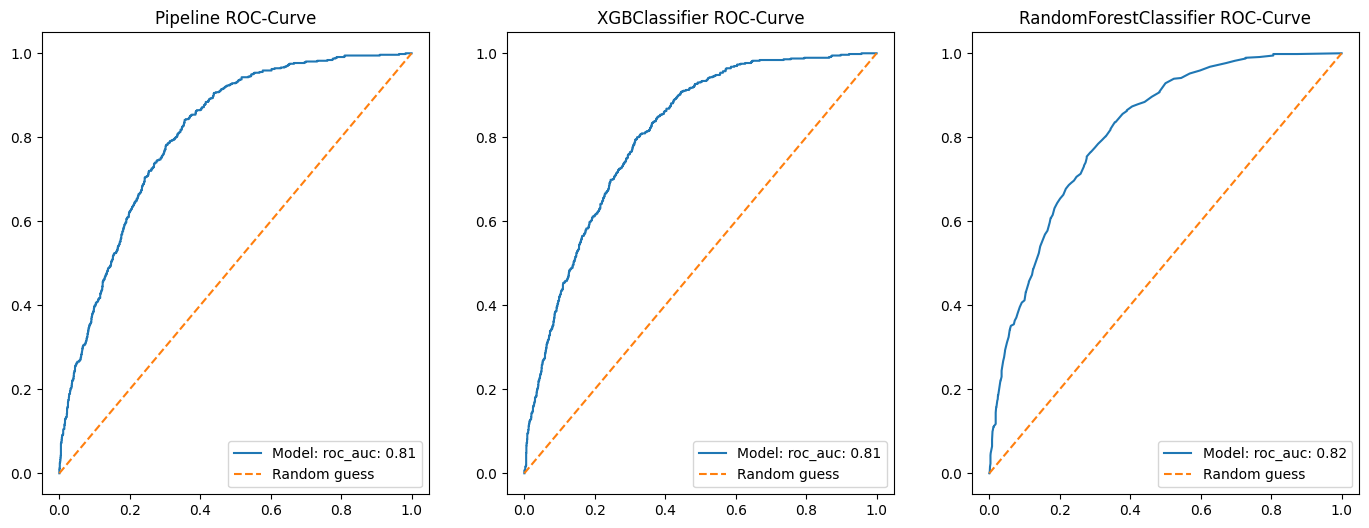

In [1245]:
fig, ax = plt.subplots(1, 3, figsize=(17, 6))
plt.sca(ax[0])
model_utils.plot_roc_curve(xgb_smote_model, y_test, xgb_smote_pred_proba)
plt.sca(ax[1])
model_utils.plot_roc_curve(xgb_model, y_test, xgb_pred_proba)
plt.sca(ax[2])
model_utils.plot_roc_curve(rf_model, y_test, rf_pred_proba)

I'll try RandomizedSearchCV for hyperparameter tuning

In [307]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
param_grid = {
    'xgb__n_estimators': [100, 200, 300, 500],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__max_depth': [3, 4, 5, 6, 8, 10],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__gamma': [0, 0.1, 0.2, 0.5],
    'xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'xgb_scale_pos_weight': [3, 5, 8]
}
kfold = StratifiedKFold(n_splits=6)
xgb_model = XGBClassifier()

rand_cv = RandomizedSearchCV(xgb_model, param_distributions=param_grid, cv=kfold, scoring='roc_auc', n_iter=50, verbose=1, n_jobs=1)
rand_cv.fit(X_train, y_train)

Fitting 6 folds for each of 50 candidates, totalling 300 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'xgb__colsample_bytree': [0.6, 0.7, ...], 'xgb__gamma': [0, 0.1, ...], 'xgb__learning_rate': [0.01, 0.05, ...], 'xgb__max_depth': [3, 4, ...], ...}"
,n_iter,50
,scoring,'roc_auc'
,n_jobs,1
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [326]:
best_xgb_params = rand_cv.best_params_
best_xgb_estimator = rand_cv.best_estimator_
best_xgb_params, rand_cv.best_score_

({'xgb_scale_pos_weight': 8,
  'xgb__subsample': 0.8,
  'xgb__n_estimators': 100,
  'xgb__min_child_weight': 3,
  'xgb__max_depth': 8,
  'xgb__learning_rate': 0.2,
  'xgb__gamma': 0.2,
  'xgb__colsample_bytree': 0.7},
 np.float64(0.822233072382046))

XGBClassifier
Train: 0.9612576064908722 | Test: 0.7652626597255088 | Accuracy: 0.7652626597255088
XGBClassifier
ROC AUC SCORE: 0.811

Classification report

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1552
           1       0.57      0.49      0.52       561

    accuracy                           0.77      2113
   macro avg       0.70      0.68      0.68      2113
weighted avg       0.76      0.77      0.76      2113



,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


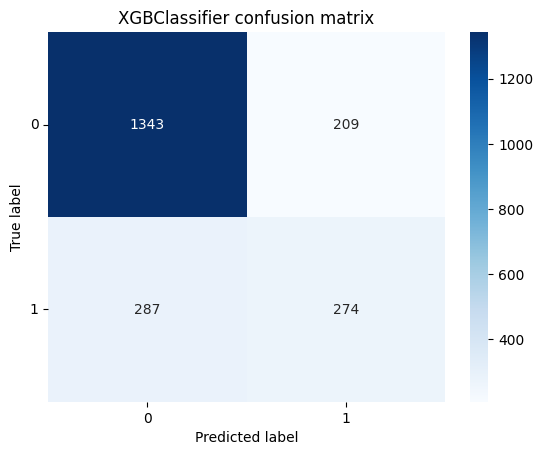

In [435]:
best_xgb_model, best_xgb_pred, best_xgb_pred_proba = model_utils.train_model(best_xgb_estimator, [X_train, X_test, y_train, y_test])
best_xgb_recall, best_xgb_precision, best_xgb_f1 = model_utils.evaluate_model(best_xgb_model, y_test, best_xgb_pred, best_xgb_pred_proba, True)
best_xgb_model

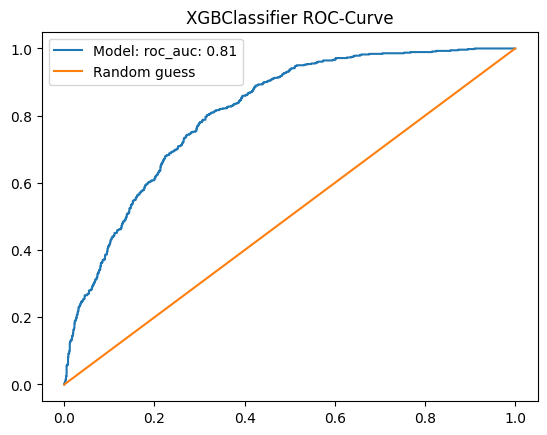

In [329]:
model_utils.plot_roc_curve(best_xgb_model, y_test, best_xgb_pred_proba)

I will now switch to optuna for more robust hyperparameter tuning

In [336]:
import optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1500),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 15),        
        # Boilerplate
        'objective': 'binary:logistic',
        'n_jobs': -1,
        'random_state': 42,
        'verbosity': 0
    }    

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
    f2_scores = []

    X_values = X_train.values
    y_values = y_train.values
    for train_idx, test_idx in kf.split(X_values, y_values):
        X_tr, X_test = X_values[train_idx], X_values[test_idx]
        y_tr, y_test = y_values[train_idx], y_values[test_idx]

        model = XGBClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = fbeta_score(y_test, y_pred, beta=3)
        f2_scores.append(score)
        trial.report(score, step=0)
        if trial.should_prune():
            raise optuna.TrialPruned()
    return sum(f2_scores)/ len(f2_scores)


study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100, timeout=600)
print(f"Best Trial: {study.best_value}")
print(f"Best Paramers\n {study.best_params}")

[I 2025-12-18 14:10:18,688] A new study created in memory with name: no-name-df718964-0a96-49e1-97df-330986715c4d
[I 2025-12-18 14:10:29,170] Trial 0 finished with value: 0.9407258723436739 and parameters: {'n_estimators': 341, 'learning_rate': 0.007273961766356479, 'max_depth': 11, 'subsample': 0.8093675110554139, 'colsample_bytree': 0.6988251000794723, 'gamma': 1.728979220525451, 'min_child_weight': 3, 'scale_pos_weight': 6.390464334481505}. Best is trial 0 with value: 0.9407258723436739.
[I 2025-12-18 14:10:41,794] Trial 1 finished with value: 0.8700189330399933 and parameters: {'n_estimators': 973, 'learning_rate': 0.0051844014901741035, 'max_depth': 6, 'subsample': 0.778159342309497, 'colsample_bytree': 0.9765363389310486, 'gamma': 3.979419315416502, 'min_child_weight': 9, 'scale_pos_weight': 4.487165606332447}. Best is trial 0 with value: 0.9407258723436739.
[I 2025-12-18 14:10:49,357] Trial 2 finished with value: 0.954823662473931 and parameters: {'n_estimators': 485, 'learning_

Best Trial: 0.9987025464806356
Best Paramers
 {'n_estimators': 1168, 'learning_rate': 0.046800193857880486, 'max_depth': 11, 'subsample': 0.747897841213388, 'colsample_bytree': 0.9950409803692712, 'gamma': 0.01685081522974352, 'min_child_weight': 1, 'scale_pos_weight': 12.396614228826278}


In [337]:
study.best_value

0.9987025464806356

In [341]:
best_study_params = study.best_params
best_study_params

{'n_estimators': 1168,
 'learning_rate': 0.046800193857880486,
 'max_depth': 11,
 'subsample': 0.747897841213388,
 'colsample_bytree': 0.9950409803692712,
 'gamma': 0.01685081522974352,
 'min_child_weight': 1,
 'scale_pos_weight': 12.396614228826278}

In [436]:
study_clf = XGBClassifier(**best_study_params)
best_study_model, best_study_preds, best_study_pred_proba = model_utils.train_model(study_clf, [X_train, X_test, y_train, y_test])
xgb_study_recall, xgb_study_precision, xgb_study_f1 = model_utils.evaluate_model(best_study_model, y_test, best_study_preds, best_study_pred_proba)

XGBClassifier
Train: 0.996551724137931 | Test: 0.751538097491718 | Accuracy: 0.751538097491718
XGBClassifier
ROC AUC SCORE: 0.807

Classification report

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1552
           1       0.53      0.60      0.56       561

    accuracy                           0.75      2113
   macro avg       0.69      0.70      0.69      2113
weighted avg       0.76      0.75      0.76      2113



In [350]:
from optuna.visualization import plot_optimization_history, plot_param_importances
plot_optimization_history(study).show()

In [351]:
plot_param_importances(study).show()

Interestingly, `LogisticRegression` has outperformed my sophisticted and complex models, this suggests that feature engineering has been able to breakdown these complex signals into simpler ones that can easily be fitted by a `Linear` model

In [1246]:
tuned_logreg_grid = model_utils.tune_logistic_regression(LogisticRegression(random_state=42, max_iter=3000), X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


LogisticRegression
Train: 0.7527383367139959 | Test: 0.7212494084240416 | Accuracy: 0.7212494084240416
LogisticRegression
ROC AUC SCORE: 0.830

Classification report

              precision    recall  f1-score   support

           0       0.91      0.69      0.78      1552
           1       0.48      0.80      0.60       561

    accuracy                           0.72      2113
   macro avg       0.70      0.75      0.69      2113
weighted avg       0.79      0.72      0.74      2113



(0.803921568627451, 0.48494623655913977, 0.6049631120053656)

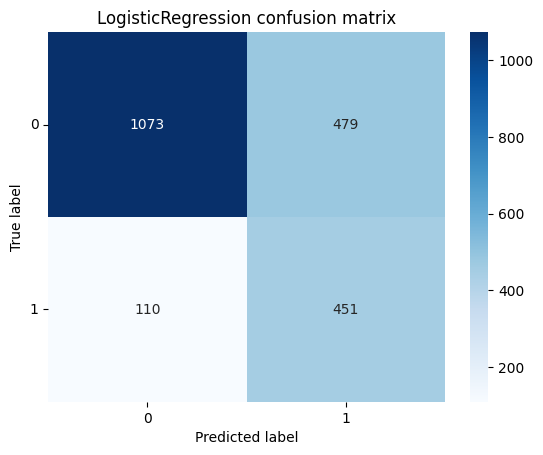

In [1247]:
tuned_logreg, tuned_logreg_preds, tuned_logreg_pred_probs = model_utils.train_model(tuned_logreg_grid.best_estimator_, [X_train, X_test, y_train, y_test])
model_utils.evaluate_model(tuned_logreg, y_test, tuned_logreg_preds, tuned_logreg_pred_probs, plot_confusion_matrix=True)

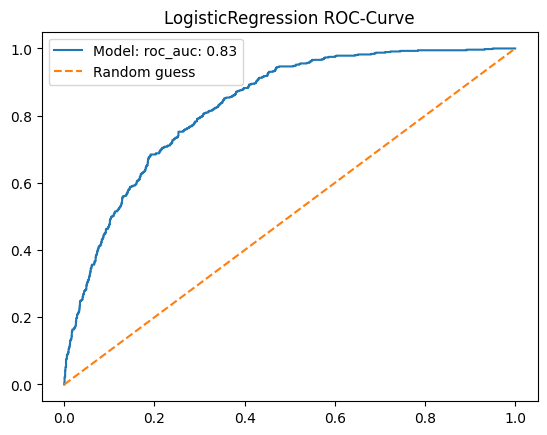

In [1248]:
model_utils.plot_roc_curve(tuned_logreg, y_test, tuned_logreg_pred_probs)

,threshold,precision,recall
1282,0.296408,0.510870,0.754011
1285,0.298433,0.510303,0.750446
1283,0.297158,0.510278,0.752228
1281,0.296302,0.510253,0.754011
1284,0.297724,0.509685,0.750446
...,...,...,...
990,0.168725,0.442565,0.885918
987,0.168353,0.442274,0.887701
989,0.168593,0.442171,0.885918
986,0.168312,0.441881,0.887701


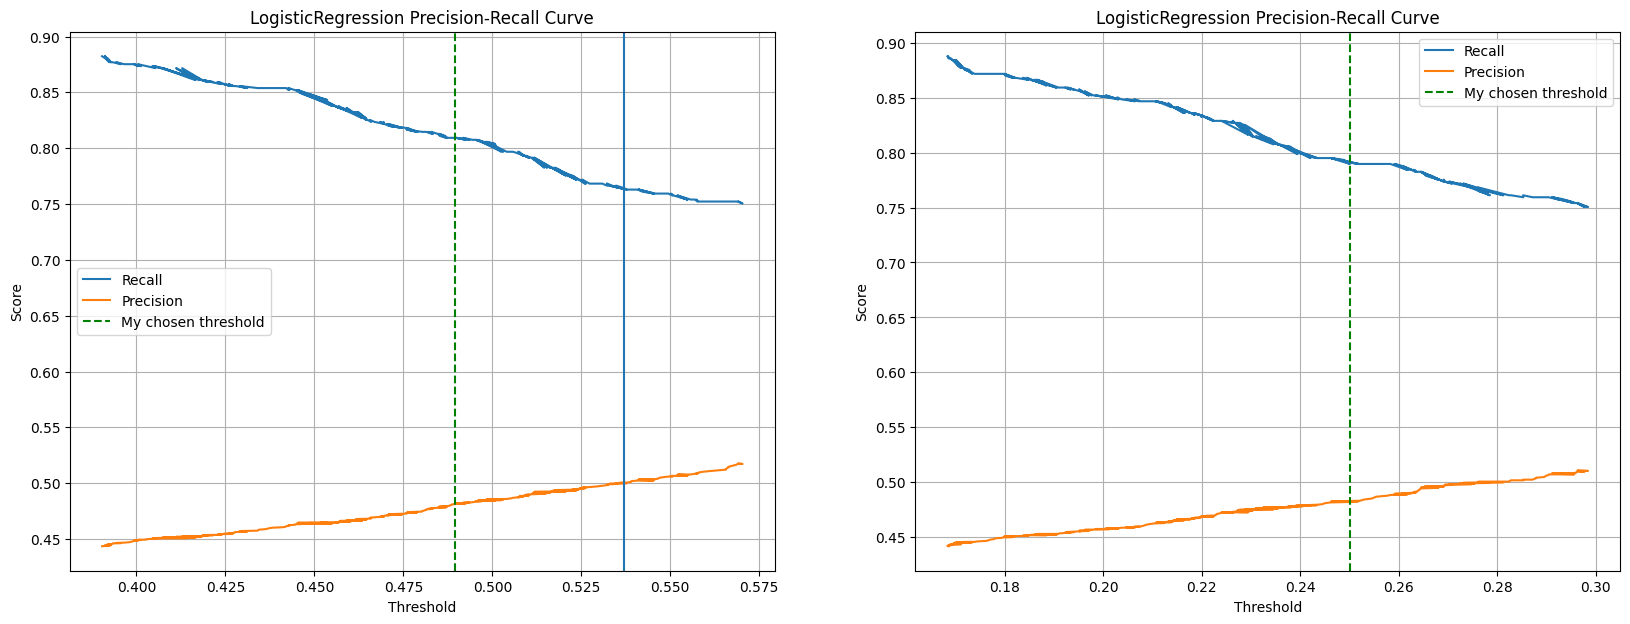

In [1249]:
fig, ax= plt.subplots(1, 2, figsize=(20, 7))
plt.sca(ax[0])
model_utils.plot_precision_recall(tuned_logreg, y_test, tuned_logreg_pred_probs)
plt.axvline(x=.537)
plt.sca(ax[1])
model_utils.plot_precision_recall(logreg, y_test, logreg_pred_proba, chosen_threshold=.25)
# plt.sca(ax[2])
# model_utils.plot_precision_recall(best_xgb_model, y_test, best_xgb_pred_proba)
# plt.sca(ax[3])
# model_utils.plot_precision_recall(best_study_model, y_test, best_study_pred_proba)
# model_utils.plot_precision_recall(xgb_model, y_test, xgb_pred_proba)

From the above plots, we can see that `LogisticRegression` outperforms the other models on both `precision` and `recall`

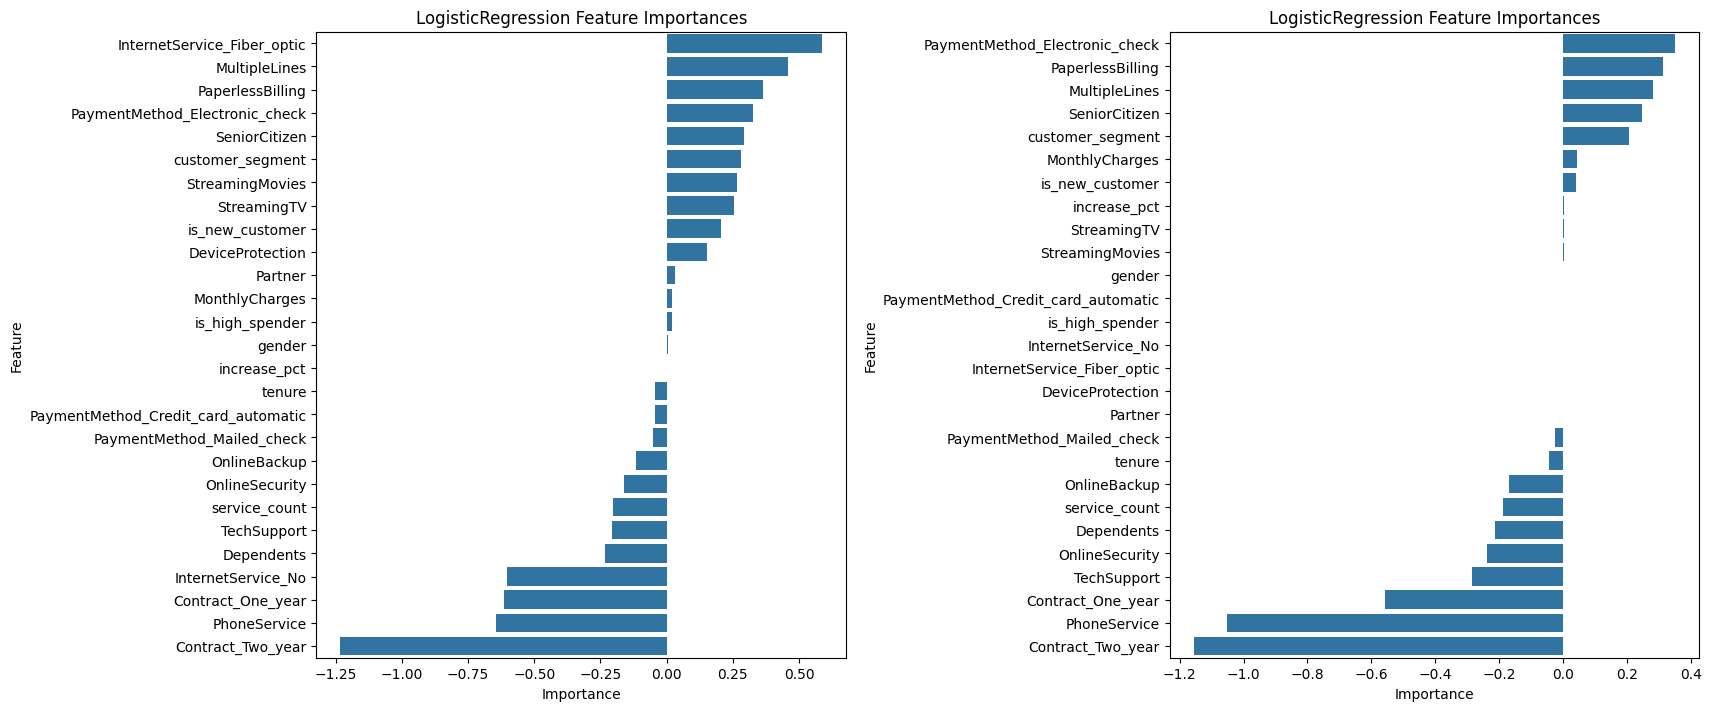

In [1250]:
fig, ax= plt.subplots(1, 2, figsize=(17,7), constrained_layout=True)
plt.sca(ax[0])
logreg_feat_imp = model_utils.plot_feature_importance(logreg)
plt.sca(ax[1])
tuned_logreg_feat_imp = model_utils.plot_feature_importance(tuned_logreg)

I used `l1` penalty for `tuned_logistic_reg` and `l2` penalty for `logreg`. From the feature importance plot above, we see that `l1` kills off numerous features by shrinking their coefficients to zero while `l2` shrinks those feature towards zero, ensuring that all features with different weights are retained. `l1` will be better for explainability but we mght lose some information. 

In [1251]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df_cols = X_train.columns
cols_to_scale = [col for col in [col for col in df_cols if X_train[col].dtype!=bool] if X_train[col].max()>5]
X_train_copy, X_test_copy = X_train.copy(), X_test.copy()
scaler = StandardScaler()
scaled_train_cols = scaler.fit_transform(X_train_copy[cols_to_scale])
scaled_test_cols = scaler.transform(X_test_copy[cols_to_scale])
X_train_copy, X_test_copy =X_train_copy.drop(cols_to_scale, axis=1), X_test_copy.drop(cols_to_scale, axis=1)
X_train_copy[cols_to_scale], X_test_copy[cols_to_scale] = scaled_train_cols, scaled_test_cols

In [659]:
scaled_logreg_grid =  model_utils.tune_logistic_regression(LogisticRegression(random_state=42, max_iter=3000), X_train_copy, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


LogisticRegression
Train: 0.8150101419878296 | Test: 0.7931850449597728 | Accuracy: 0.7931850449597728
LogisticRegression
ROC AUC SCORE: 0.831

Classification report

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1552
           1       0.63      0.55      0.58       561

    accuracy                           0.79      2113
   macro avg       0.74      0.71      0.72      2113
weighted avg       0.79      0.79      0.79      2113



(0.5472370766488414, 0.6265306122448979, 0.5842055185537584)

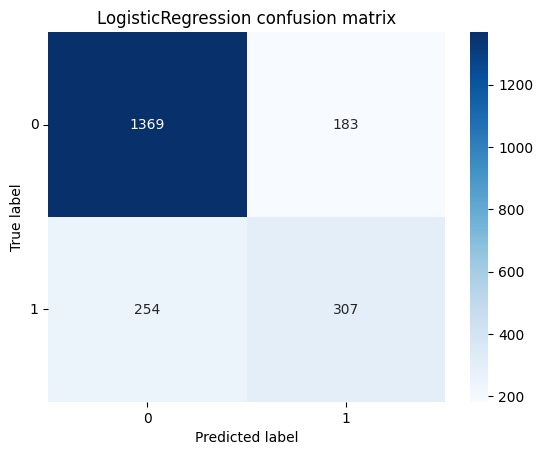

In [661]:
scaled_logreg, scaled_logreg_pred, scaled_logreg_pred_probs = model_utils.train_model(LogisticRegression(max_iter=4000), [X_train_copy, X_test_copy, y_train, y_test])
model_utils.evaluate_model(scaled_logreg, y_test, scaled_logreg_pred, scaled_logreg_pred_probs, True)

Since I'm not seeing any meaningful performance increase with scaling, I will stick with my first tuned LogisticRegression model

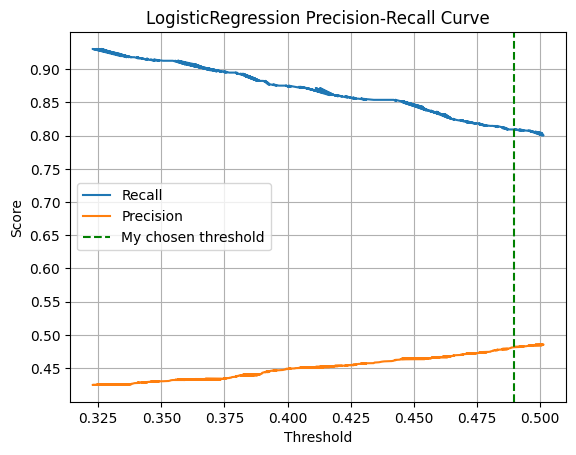

In [1252]:
tuned_logreg_trade_df = model_utils.plot_precision_recall(tuned_logreg, y_test, tuned_logreg_pred_probs, recall_threshold=.80)

In [1253]:
tuned_logreg_trade_df[(tuned_logreg_trade_df['precision']>=.48) & (tuned_logreg_trade_df['recall']>.7)].head(5)

,threshold,precision,recall
1179,0.498438,0.485499,0.805704
1181,0.500671,0.485468,0.803922
1185,0.501352,0.485405,0.800357
1178,0.497969,0.484979,0.805704
1180,0.500550,0.484946,0.803922


I will be using a threshold of `0.489506` for my predictions since at this point, i have a `recall` of `0.811052` and a `precision` of `0.487152`

In [84]:
tuned_logreg_trade_df = model_utils.plot_precision_recall(tuned_logreg, y_test, tuned_logreg_pred_probs, recall_threshold=.80)

NameError: name 'tuned_logreg' is not defined

In [90]:
import shap
logreg_shap_explainer= shap.LinearExplainer(model, X_train)
logreg_shap_values = logreg_shap_explainer.shap_values(X_test)
fig, ax=plt.subplots(figsize=(10,5))
shap.summary_plot(logreg_shap_values, X_test, plot_type='bar', show=False)

plt.tight_layout()

Saving the models which i have used here for future inference

In [ ]:
import joblib
X_train_sample = X_train.sample(100)
def save_necessary_models():    
    joblib.dump(initial_columns, "models/initial_columns.pkl")
    joblib.dump(model_one_hot_encoder, "models/one_hot_encoder.pkl")
    joblib.dump(tuned_logreg, "models/tuned_logistic_regression.pkl")
    joblib.dump(model_scaler, "models/model_scaler.pkl")
    joblib.dump(model_kmeans, "models/model_kmeans.pkl")
    joblib.dump(X_train_sample, "models/X_train_sample.pkl")
save_necessary_models()

##### Loading saved models

In [4]:
initial_columns, model, one_hot_encoder, scaler, kmeans, shap_explainer = inference.load_models()

In [1219]:
random_data = telecom_df.iloc[np.random.randint(0, 3000)]
print(random_data['Churn'])
sample_data = random_data.to_dict()
sample_df = inference.preprocess_customer_data(sample_data, model, one_hot_encoder, scaler, model_kmeans).drop(['customerID', 'Churn'], axis=1)
sample_df.columns == tuned_logreg.feature_names_in_
# processed_customer_data = inference.preprocess_customer_data(sample_data, one_hot_encoder, scaler, model_kmeans, model)
# prediction, model_confidence = inference.predict_churn(processed_customer_data, model)
# prediction, model_confidence

No


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [12]:
shap_features= X_test.columns.tolist()
shap_values_list = shap_values.tolist()
shap_avg_values = np.abs(shap_values_list).mean(axis=0)
shap_avg_values_list = shap_avg_values.tolist()
shap_df = pd.DataFrame(data=shap_avg_values_list, index=shap_features, columns=['Importance']).sort_values('Importance', ascending=False)

In [30]:
shap_df.head(5)

,Importance
MonthlyCharges,1.126993
tenure,0.921333
Contract_Two_year,0.399044
service_count,0.367945
customer_segment,0.205238


In [43]:
top_shap_feat = shap_df.head(5).index.tolist()
top_shap_feat

['MonthlyCharges',
 'tenure',
 'Contract_Two_year',
 'service_count',
 'customer_segment']

In [68]:
# shap.dependence_plot('tenure', shap_values, X_test, show=False, interaction_index='service_count')

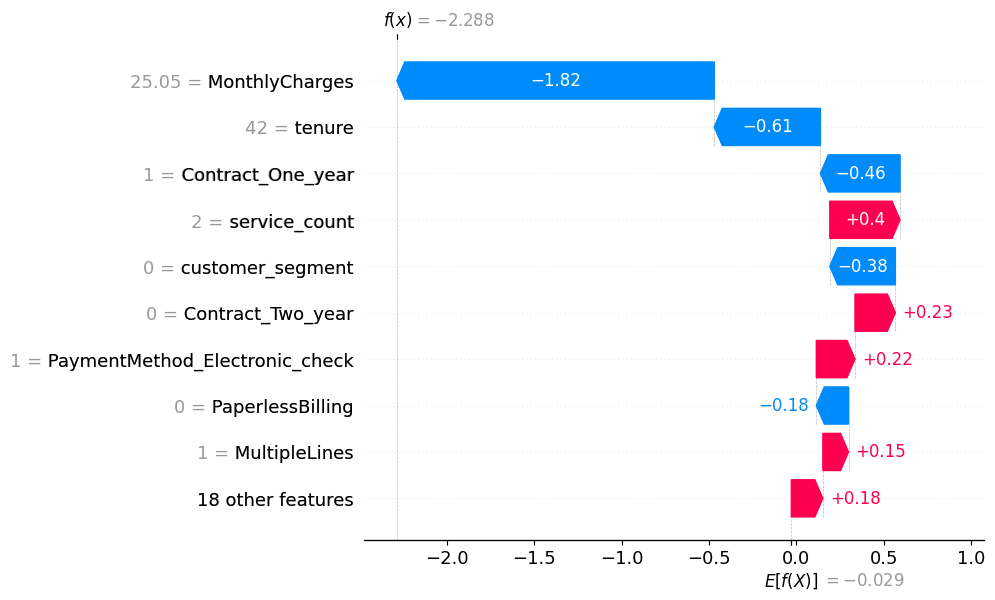

In [5]:
import shap
cust_data = X_train.iloc[2, :]
shap_explainer = shap.LinearExplainer(model, X_train)
shap_values = shap_explainer.shap_values(cust_data)
# pred_prob= model.predict_proba(cust_data.values)[0, 1]
# logreg_shap_explainer= shap.LinearExplainer(model, X_train)
# logreg_shap_values = logreg_shap_explainer.shap_values(X_test)
explanation = shap.Explanation(values=shap_values, base_values=shap_explainer.expected_value,
                data=cust_data.values, feature_names= X_test.columns.tolist())
shap_values.shape
shap.waterfall_plot(explanation, show=True)
# plt.title(f"Explanation for Churn Risk: {pred_prob}")

In [14]:
cust_shap_data = {i: round(float(j), 2) for i,j in zip(cust_data.index.tolist(), explanation.values)}
top_churn_factors = sorted(cust_shap_data.items(), key=lambda x: abs(x[1]), reverse=True)[:9]

In [42]:
explanation.feature_names

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'MonthlyCharges',
 'is_high_spender',
 'is_new_customer',
 'service_count',
 'increase_pct',
 'customer_segment',
 'InternetService_Fiber_optic',
 'InternetService_No',
 'Contract_One_year',
 'Contract_Two_year',
 'PaymentMethod_Credit_card_automatic',
 'PaymentMethod_Electronic_check',
 'PaymentMethod_Mailed_check']

In [ ]:
groq_response = groq_chat(prompt)
print(groq_response['response'])

**EXPLANATION (2-3 sentences):**  
The customer’s churn risk is modest (23 %) but is being pushed upward by a relatively high number of services, the use of electronic‑check payments, and the presence of a two‑year contract that may be up for renewal soon. At the same time, low monthly charges, a long tenure and a one‑year contract are pulling the risk down, indicating the customer is generally satisfied but could be tempted by a better offer or a smoother payment option.

**RECOMMENDATIONS (3 bullet points):**  
- **Offer a payment‑method upgrade incentive** (e.g., a small discount or reward for switching from electronic check to automatic credit‑card billing) to reduce the churn signal tied to the current payment method.  
- **Simplify the service bundle** by proposing a tailored, slightly lower‑priced package that retains the most‑used services, addressing the “service_count” driver that can cause complexity fatigue.  
- **Proactively engage before the contract renewal** with a pers

**EXPLANATION (2-3 sentences):**  
The customer’s churn risk is modest (23 %) but is being pushed upward by a relatively high number of services, the use of electronic‑check payments, and the presence of a two‑year contract that may be up for renewal soon. At the same time, low monthly charges, a long tenure and a one‑year contract are pulling the risk down, indicating the customer is generally satisfied but could be tempted by a better offer or a smoother payment option.

**RECOMMENDATIONS (3 bullet points):**  
- **Offer a payment‑method upgrade incentive** (e.g., a small discount or reward for switching from electronic check to automatic credit‑card billing) to reduce the churn signal tied to the current payment method.  
- **Simplify the service bundle** by proposing a tailored, slightly lower‑priced package that retains the most‑used services, addressing the “service_count” driver that can cause complexity fatigue.  
- **Proactively engage before the contract renewal** with a personalized loyalty offer (e.g., a one‑time credit or added feature) to lock the customer into the existing term and counteract the renewal‑related churn risk.

# Conclusion

### Key Findings
This notebook successfully built a customer churn prediction system with the following highlights:

1. **Model Performance**: The final model achieves strong predictive performance with interpretable results. `recall` was chosen as the primary evaluation metric as it is more important for the system to catch as many churners as possible.
2. **Key Churn Drivers**: 
    - Contract type (month-to-month contracts have higher churn)
    - Payment method (electronic check users churn more)
    - Tenure (newer customers are at higher risk)
    - Service count and complexity
            
3. **Business Impact**: 
    - AI-powered recommendations provide actionable insights for customer retention
    - SHAP enables transparent decision-making
    - Feature engineering improved model performance significantly.

### Next Steps
1. **Deploy to Production**: Integrate the model into customer management systems
2. **A/B Testing**: Test retention strategies on predicted high-risk customers
3. **Model Monitoring**: Track model performance and retrain as needed
4. **Feature Expansion**: Incorporate additional data sources (usage patterns, support tickets, etc.)